# What's this all about?

A low level intro to the use of numerical libraries (mainly Pytorch but also Numpy and Tensorflow) for machine learning.

## Goal of this lecture

1. Get everyone familiar with the basics of array-manipulation. 
2. Make sure even those people already familiar learn something new.
3. Introduce pytorch from the bottom-up.


## Array libraries - what are they?  

Libraries like Numpy, PyTorch, and Tensorflow use `N-dimensional arrays` as a basic datatype.   They allow you to manipulate arrays much more compactily and faster than if you were to use native python.  Behind the scenes, they do all the looping in C - which will typically be around 20-100x faster than doing it in python.



In [ ]:
from timeit import timeit
t1=timeit("sum(ai*bi for ai, bi in zip(a, b))", setup="import random; N=10000000; a=[random.gauss(0, 1) for _ in range(N)]; b=[random.gauss(0, 1) for _ in range(N)]", number = 10)
t2=timeit("(a*b).sum()", setup="import numpy as np; N=10000000; a, b = np.random.randn(2, N)", number = 10)
print(f"With python looping: t={t1:.3f}, with numpy looping: t={t2:.3f}.  Speedup factor: {t1/t2:.0f}x")

With python looping: t=9.208, with numpy looping: t=0.352.  Speedup factor: 26x



# Example - 2 blobs of points

Lets create a random set of N (x, y) points "A" from a standard normal distribution, and another set of M (x, y) points "B" from a normal distribution centered around (x=3, y=2).  Then join them into one big set of points C, and find the matrix of distances "D" between each pair of points.

**Mathematically, we could denote this:**

$a \in \mathbb R ^{N \times 2}: a_{n,i} \sim \mathcal N(\mu_a, 1): \mu_a := (0, 0)$

$b \in \mathbb R ^{M \times 2}: b_{m,j} \sim \mathcal N(\mu_a, 1): \mu_b:=(5, 2)$

$c \in \mathbb R ^{(N+M) \times 2}: c_{k, d} : = \begin{cases}a_{k, d} & \text{if } (k\leq N) \\ b_{k-N, d} & \text{otherwise} \end{cases}$

$d \in \mathbb R_{\geq0}^{(N+M) \times (N+M)} : d_{i,j} := \sqrt{\sum_{d=1}^2 (c_{i,d}-c_{j,d})^2}$


In [ ]:
# Setup 
N = 5
M = 7
D = 2
mu_a = (0, 0)
mu_b = (5, 2)

In [ ]:
# Example 1: Native python in long-form
import random

def matrix_to_string(arr): 
  string_rep = ""
  for row in arr: 
    string_rep+="\t".join(f"{x:.2f}" for x in row) + "\n"
  return string_rep

points_a = []
for n in range(N): 
  row = []
  for d in range(D): 
    row.append(random.gauss(mu_a[d], 1))
  points_a.append(row)
print(f"A: \n{matrix_to_string(points_a)}")

points_b = []
for j in range(M): 
  row = []
  for d in range(D): 
    row.append(random.gauss(mu_b[d], 1))
  points_b.append(row)
print(f"B: \n{matrix_to_string(points_b)}")

points_c = points_a + points_b  # Note: Since these are lists, "+" means "concatenation"
print(f"C: \n{matrix_to_string(points_c)}")

distance_mat = []
for i in range(len(points_c)): 
  row = []
  for j in range(len(points_c)):
    distance_sq = 0
    for d in range(D):
      distance_sq += (points_c[i][d]-points_c[j][d])**2
    row.append(distance_sq**0.5)
  distance_mat.append(row)
print(f"D: \n{matrix_to_string(distance_mat)}")


A: 
-0.93	-0.36
-0.51	-0.11
0.29	-0.82
-0.45	0.97
0.40	-0.63

B: 
4.27	1.18
4.84	2.53
5.20	2.60
4.41	1.04
4.36	3.55
4.90	1.31
3.90	1.74

C: 
-0.93	-0.36
-0.51	-0.11
0.29	-0.82
-0.45	0.97
0.40	-0.63
4.27	1.18
4.84	2.53
5.20	2.60
4.41	1.04
4.36	3.55
4.90	1.31
3.90	1.74

D: 
0.00	0.48	1.30	1.41	1.36	5.42	6.45	6.80	5.52	6.57	6.06	5.26
0.48	0.00	1.07	1.08	1.05	4.95	5.97	6.32	5.06	6.09	5.60	4.78
1.30	1.07	0.00	1.94	0.22	4.45	5.65	5.98	4.52	5.97	5.08	4.42
1.41	1.08	1.94	0.00	1.81	4.72	5.52	5.88	4.87	5.46	5.37	4.42
1.36	1.05	0.22	1.81	0.00	4.27	5.45	5.78	4.34	5.75	4.90	4.22
5.42	4.95	4.45	4.72	4.27	0.00	1.47	1.70	0.20	2.37	0.65	0.67
6.45	5.97	5.65	5.52	5.45	1.47	0.00	0.36	1.55	1.13	1.22	1.23
6.80	6.32	5.98	5.88	5.78	1.70	0.36	0.00	1.75	1.26	1.33	1.56
5.52	5.06	4.52	4.87	4.34	0.20	1.55	1.75	0.00	2.51	0.56	0.87
6.57	6.09	5.97	5.46	5.75	2.37	1.13	1.26	2.51	0.00	2.31	1.87
6.06	5.60	5.08	5.37	4.90	0.65	1.22	1.33	0.56	2.31	0.00	1.10
5.26	4.78	4.42	4.42	4.22	0.67	1.23	1.56	0.87	1.87	1.10	0.00



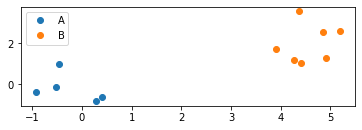

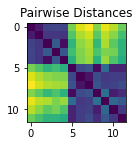

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_everything(points_a, points_b, distances, show=True): 
  points_a = np.asarray(points_a)
  points_b = np.asarray(points_b)
  distances = np.asarray(distances)
  plt.subplot(2, 1, 1)
  plt.plot(points_a[:, 0], points_a[:, 1], label="A", linestyle='', marker='o')
  plt.plot(points_b[:, 0], points_b[:, 1], label="B", linestyle='', marker='o')
  plt.legend()
  plt.show()
  plt.subplot(2, 1, 2)
  plt.imshow(distances)
  plt.title("Pairwise Distances")
  if show:
    plt.show()


plot_everything(points_a, points_b, distance_mat)

# So much code!

The math described the same things as the code, but it came in 4 compact lines, vs 40 lines of code!  Can't we make the code more compact?

If only there was some way to compress things into a list so we could comprehend it more easily....

If only there was something like...

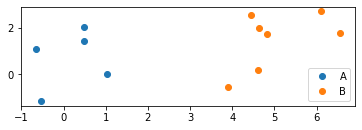

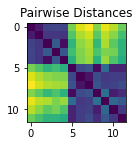

In [ ]:
# List comprehensions!
a = [[random.gauss(mu_a[d], 1) for d in range(D)] for n in range(N)]
b = [[random.gauss(mu_b[d], 1) for d in range(D)] for n in range(M)]
c = points_a + points_b  # Note: Since these are lists, "+" means "concatenation"
d = [[sum((cid-cjd)**2 for cid, cjd in zip(ci, cj))**.5 for ci in c] for cj in c]

plot_everything(a, b, d)

# Ok, that's nice, but still...

That comprehension syntax is... difficult to parse.

```
d = [[sum((cid-cjd)**2 for cid, cjd in zip(ci, cj))**.5 for ci in c] for cj in c]
```
... doesn't exactly roll of the tongue.

If only there were some more compact syntax for doing all these operations without the comprehension and looping... 

If only there was something like ...

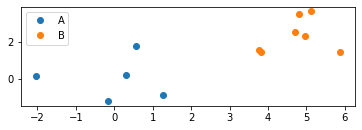

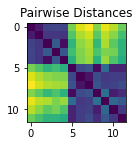

In [ ]:
# Numpy!
import numpy as np
a = np.random.randn(N, D) + mu_a
b = np.random.randn(M, D) + mu_b
c = np.concatenate([points_a, points_b], axis=0)  # Note: "+" on numpy arrays means addition, not concatenation, so we use np.concatenate
d = ((c[:, None, :]-c[None, :, :])**2).sum(axis=2)**.5
plot_everything(a, b, d)

# What just happened?

```
points_a = np.random.randn(N, D) + mu_a
```

* `np.random.randn(N, D)` Created a NxD array of normally-distributed random numbers
* `+ mu_a` added a (D-dimensional array of means).  


**Rule of broadcasting**: When 2 arguments don't have same number of dimensions, you line up the lower dimensional one to the LAST dimensions of the higher. 

So say we add a shape (3, 2) array x to a shape (2, ) array y:

```
[ x[0,0]  x[0,1] ]   +   [ y[0]  y[1] ]
[ x[1,0]  x[1,1] ]
[ x[2,0]  x[2,1] ]

... causes y to be broadcasted to the shape of x... 

[ x[0,0]  x[0,1] ]   +   [ y[0]  y[1] ]
[ x[1,0]  x[1,1] ]   +   [ y[0]  y[1] ]
[ x[2,0]  x[2,1] ]   +   [ y[0]  y[1] ]

... resulting in ...

[ x[0,0]+y[0]  x[0,1]+y[1] ]
[ x[1,0]+y[0]  x[1,1]+y[1] ]
[ x[2,0]+y[0]  x[2,1]+y[1] ]  

```

Broadcasting quiz...  Predict shapes of the result of `a+b`, or error if there is one, when

```
a.shape==(3, 2), b.shape=(2, ) ...  (3, 2)

a.shape==(3, 2), b.shape=(3, ) ... error

a.shape==(3, 2), b.shape=(3, 1) ... (3, 2)

a.shape==(3, 2), b.shape=() ...(3, 2)

a.shape==(3, 2), b.shape=(1, 2) ... (3, 2)

a.shape==(1, 2), b.shape=(2, ) ... (1, 2)

a.shape==(1, 2), b.shape=(3, 2) ...(3, 2)

a.shape==(2, ), b.shape=(3, 2) ... (3, 2)

a.shape==(2, ), b.shape=(3, ) ... error

a.shape==(3, ), b.shape=(3, ) ... (3, )

a.shape==(), b.shape=(3, ) ...

a.shape==(3, 1, 2), b.shape=(2, ) ... (3, 1, 2)

a.shape==(3, 1, 2), b.shape=(3, 2) .. (3, 3, 2). --. b-> (1, 3, 2)   a-> (3, 3, 2)

a.shape==(3, 2, 2), b.shape=(3, 2) ...err

a.shape==(3, 1, 2), b.shape=(1, 3, 2) ...(3, 3, 2)
```

Continuing through what just happened...

`points_c = np.concatenate([points_a, points_b], axis=0)`

* We take our `Nx2` and `Mx2` array, and concatenate them across the 0'th axis to form a `(N+M)x2` array

**Quiz Question**

What would 
`points_c = np.concatenate([points_a, points_b], axis=1)`
do?
... error

Moving on...

`points_c[:, None, :]`



* `None` or equivalently `np.newaxis` inserts a singleton dimension.  i.e. if `points_c` has shape `(C, 2)`, then `points_c[:, None, :]` (or `points_c[:, np.newaxis, :]`) has shape `(C, 1, 2)`.

* That sets us up for broadcasting


**Quiz Question**
c.shape == (C, 2)

1. What shape does `points_c[:, None, :]` have? .. (C, 1, 2)

1. What shape does `points_c[None, :, :]` have?  (1, C, 2)

1. What shape does `points_c[:, None, :]-points_c[None, :, :]` have?

(C, C, 2)

1. What shape would `points_a[:, None, :]-points_b[None, :, :]` have?

(A, B, 2)

Moving on...

`((points_c[:, None, :]-points_c[None, :, :])**2).sum(axis=2)**.5`


d(a, b) = (((a[0]-b[0])**2+(a[1]-b[1])**2).sum()**.5


* The `**2` just squares every element in the array
* The `.sum(axis=...)` method (or `np.sum(..., axis=...)`) sums all elements along a dimnsion.  
* The `**.5` just takes the square root of every element in the array.




**Quiz**

If `x` has shape `(4, 5, 6)`: 
* What shape does `x.sum(axis=2)` have?  (4, 5)
* What shape does `x.sum(axis=1)` have?  (4,6)
* What shape does `x.sum(axis=0)` have?  (5,6)
* What shape does `x.sum(axis=2).sum(axis=1)`  (4, ) have?
* What shape does `x.sum(axis=0).sum(axis=1)` have?  (5, )

... So Finally 


```
distance_mat = ((points_c[:, None, :]-points_c[None, :, :])**2).sum(axis=2)**.5
```
points_c (C,2) 


What shape should `distance_mat` have? (C,C)


# Slicing

What if we don't care about the distance between every pair of points, but only between points in different groupd (a vs b)?

```
a=[4, 5, 6, 7, 8]
a[2:5] = ???  [6,7,8]
a[2:] = ??? [6,7,8]
a[:5] = ???
a[:-2] = ??? [4,5,6]
a[1:-2] = ???
a[::2] = ?? [4,6,8]
a[::-1] = ??? [8,7,6,5,4]
a[-2:-1] = ???
a[-2:None] = ??? [7,8]

a[3:18] = ???
a[-3:1 = ??
a[:, :] = ???
a[..., [1, 2]] = ???

if a is shape (n, 3) ... (n)
if a is shape (n, m, 3)  (n, m)
```
You can also slice 2d arrays

```
a = [
  [1, 2, 3, 4], 
  [5, 6, 7, 8], 
  [9, 10, 11, 12]
  ]
a[:2, :2] == ?[[1,2],[5,6]
a[2:, 3:] == ??? [[12]]
a[2:] == ??? [[9, 10, 11, 20][
a[:, 3:] == [4][8][12]
```
Internal note - a slice MAY return a view of an array - not a copy.  So be careful - and in general - avoid assigning to slices in place unless you are sure you're not going to be using `a` anywhere else.  

```
a = np.zeros((2, 3))
b=a[1, 1:]
b+=1
print(a)
# [[0. 0. 0.]
#  [0. 1. 1.]]
```


**Quiz:** 

How do we compute the matrix of distances from each point in `A` to each point in `B`? 

How could we extract these same distances from the already computed `distance_mat` with shape `((N+M), (N+M))`?

# Matrix multiplication

A very common operation in all machine learning is matrix multipication.

Multiplying a NxD matrix "x" with a DxH matrix "w" gives you a NxH matrix.

In numpy, this can be done with `np.dot(x, w)` or the `@` operator.

In [ ]:
x = np.random.randn(3, 4)
w = np.random.randn(4, 5)
result = x @ w 

print(result.shape)
assert np.array_equal(result, np.dot(x, w))

(3, 5)


# More numpy functions

```
x = np.array([
  [1, 2, 3], 
  [4, 5, 6]
])
# Predict the following 
np.sum(x, axis=1)
np.max(x, axis=1)
np.max(x, axis=0)
np.cumsum(x, axis=1)
np.prod(x, axis=0)
np.argmax(x, axis=1)
np.diff(x, axis=1)
x.T
x @ x.T
np.einsum('ik,jk->ij', x, x)
2**x
```

In [ ]:
a = np.array([3,1,4])
b = np.array([2,-3, 1])

a = np.array([[1, 2, 3], [5, 6, 7]])

np.einsum('i ,j ->ij', a, a).shape

ValueError: ignored

# Has everybody learned something?

If not... 

```
x = np.array([2, 4, 8, 2, 6, 1, 4, 7, 2])
g = np.array([0, 0, 3, 3, 1, 2, 2, 2, 2])
```
... Find the average of all x's belonging to each group with no python loops.

# Have you still not learned anything?

Ok, advanced indexing.. almost nobody knows about that ...



In [ ]:
# ---- Selecting a list of elements from an array -----
a = np.array([
    [1, 2, 3], 
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12]   
])
# and a "per_row_column_indices_array"
per_row_column_indices = [2, 0, 1, 1]

# Select the given column in each row so that you end up with [3, 4, 8, 11]

# ... In class exersize ....


# ---- Still have't learned anything? ----

# Ok, index broadcasting.

# Suppose we want to break up the above array into 3x3 "patches" - so that a[i, j] 
# returns the 3x3 patch of pixels around [i, j], with edges replicated.
# 
# a_patches[0, 0] == [
#   [1, 1, 2], 
#   [1, 1, 2], 
#   [4, 4, 5]
# ]

# a_patches[1, 1] == [
#   [1, 2, 3], 
#   [4, 5, 6], 
#   [7, 8, 9]
# ]
i_ixs = np.clip(np.arange(a.shape[0])[:, None, None, None] + np.arange(-1, 2)[None, None, :, None], 0, a.shape[0]-1)
j_ixs = np.clip(np.arange(a.shape[1])[None, :, None, None] + np.arange(-1, 2)[None, None, None, :], 0, a.shape[1]-1)
a_patches = a[i_ixs, j_ixs]
print(f"a_patches.shape = {a_patches.shape}")
print(f"a_patches[0, 0]=\n{a_patches[0, 0]}")
print(f"a_patches[1, 1]=\n{a_patches[1, 1]}")

# Backpropagation 

Almost all machine learning involves computing or estimating gradients of parameters with respect to some loss. 

E.g., Lets set up the most basic possible machine learning problem

$x=4$ : Our input data

$y=13$: Our target data

$w=3$: Our parameters

$\hat y = x w$ : Our prediction

$\mathcal L = (y-\hat y)^2$: Our loss

Our goal: Find the value of parameter $w$ what minimizes our loss $\mathcal L$

# Solving Analytically

In simple cases like this, we can just solve for w.  

At the optimal loss, 

$\frac{\partial \mathcal L}{\partial w} = 0$

So if:

$$
\begin{align}
0=\frac{\partial \mathcal L}{\partial w} &= \frac{\partial}{\partial w} (y-\hat y)^2 \\
&=\frac{\partial \mathcal L}{\partial w}(y-xw)^2\\
&=\frac{\partial \mathcal L}{\partial w}(y^2-2xwy+x^2w^2) \\
&=-2xy+2x^2w \\
→ w &= - y/x = 13/4 = 3.25
\end{align}
$$

# Why the analytical approach doesn't work every time:

What about when we use a more complex model (like a not-very-deep neural network): 

$\hat y = w_2 \sigma( x w_1)$

Where $\sigma(u)=1/(1+e^{-u})$ is some "squashing" nonlinearity?

Try solving $\frac{\partial \mathcal L}{\partial w_1} = 0$

... (Frantic scribbling of Greek symbols) ...

You can't - there is no closed-form equation solving $w_1$ in this case. 

That doesn't mean there is *no solution* - it just means you can't compute it by crunching an equation.  

There may actually be many values of $w_1$ for which $\frac{\partial \mathcal L}{\partial w} = 0$

# Then what do we do?

We may not be able to directly compute $w$ when $\frac{\partial \mathcal L}{\partial w} = 0$, but we can compute $\frac{\partial \mathcal L}{\partial w}$.  

And so long as our function is smooth (ie - $\frac{\partial \mathcal L}{\partial w} = 0$ is finite everywhere - which is true by design in all deep networks), we can approach a point for which $\frac{\partial \mathcal L}{\partial w} = 0$ by taking tiny steps in the direction opposite to $\frac{\partial \mathcal L}{\partial w}$.

# Ok, so how do we get $\frac{\partial \mathcal L}{\partial w}$ then?

Backpropagation.  Which is just a fancy name for using the chain-rule in calculus to go backwards from where $\mathcal L$ is computed to $w$.

$$
\frac{\partial \mathcal L}{\partial w} = \frac{\partial \mathcal L}{\partial \hat y} \frac{\partial \hat y}{\partial w}
$$

... Skipping details here on how this is computed ... 

# Ok, lets do this with Numpy

You can of course implement backpropagation with Numpy.  You just need to be very careful - mess up the math and your gradients will be wrong.  

```
"Backpropagation is robust to programming errors"
   - Geoff Hinton
```

Often these erros are sneaky because the system will kind of work despite them.

If only there were some numerical library that could take care of computing gradients without us having to be constantly double-checking our code... 

If only there were something like...

In [ ]:
# PyTorch!  (or TensorFlow)

import torch
from torch.autograd import Variable, grad

x = torch.tensor(4.0)
w = torch.tensor(3.0, requires_grad=True)
target = torch.tensor(13.0)


prediction = x*w 
prediction_error = target-prediction
loss = prediction_error**2
d_loss_d_w, = grad(outputs=loss, inputs=w)  # Predict - is this going to be negative or positive?


In [ ]:
for i in range(10):
  print(f"Iter: {i}, Guess: {prediction:.2f}, Target: {target}, Error: {prediction_error:.2f}, Loss: {loss:.4f}, dLoss/dw={d_loss_d_w:.2f}")

  # Apply the update
  learning_rate = 0.01 
  w.data = w.data - learning_rate * d_loss_d_w

  # Recompute the gradient
  prediction = x*w 
  prediction_error = target-prediction
  loss = prediction_error**2
  d_loss_d_w, = grad(outputs=loss, inputs=w)

# PyTorch (and Tensorflow) are also array libraries

... With very similar syntax to numpy

In [ ]:
import torch

# Pytorch has very similar syntax to numpy
a = torch.randn(N, D) + torch.tensor(mu_a)
b = torch.randn(M, D) + torch.tensor(mu_b)
c = torch.cat([a, b], axis=0)
d = ((c[:, None, :]-c[None, :, :])**2).sum(axis=2)**.5
plot_everything(a, b, d)

# Ok, lets do something semi-real.  

Remember the data we just made?  We can turn that into a classification problem: Predict whether each point belongs to A or B.

Below, we do this with only a training set.  

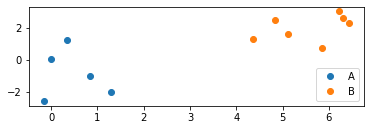

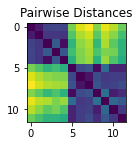

In [ ]:
# Pytorch has very similar syntax to numpy
a = torch.randn(N, D) + torch.tensor(mu_a)
b = torch.randn(M, D) + torch.tensor(mu_b)
c = torch.cat([a, b], axis=0)


labels = (torch.arange(0, N+M)>=N).float()

plot_everything(c[labels==0], c[labels==1], d)

In [ ]:
# Initialize Training training
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros((1, 1), requires_grad=True)
iteration = 0

Iteration 24
Predicted Labels: [0 0 0 0 0 1 1 1 1 1 1 1]
Ground Tr Labels: [0 0 0 0 0 1 1 1 1 1 1 1]
Prediction Score: 100.00%
Loss: 0.1194


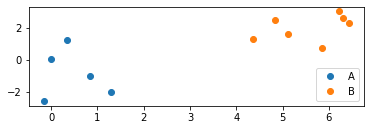

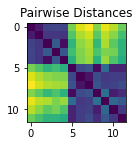

In [ ]:
# Training loop

# Forward pass - compute predictions and loss
iteration+=1
prediction = torch.nn.Sigmoid()(c @ w + b)
predicted_labels = (prediction>0.5)[:, 0]
loss = torch.nn.BCELoss()(prediction, labels[:, None])

print(f"Iteration {iteration}")
print(f"Predicted Labels: {predicted_labels.numpy().astype(int)}")
print(f"Ground Tr Labels: {labels.numpy().astype(int)}")
print(f"Prediction Score: {(predicted_labels==labels).float().mean():.2%}")
print(f"Loss: {loss:.4f}")

# Backward pass - compute gradients and update parameters 
d_loss_d_w, d_loss_d_b = grad(loss, inputs=[w, b])
learning_rate = 0.5
w.data = w.data - learning_rate*d_loss_d_w
b.data = b.data - learning_rate*d_loss_d_b

# Plot the predicted 
plot_everything(c[predicted_labels==0], c[predicted_labels==1], d)

# Bonus Task 1:

Now make a separate held-out validation set and evaluate your loss and prediction error, plotting the learning curves over time.


# Bonus Task 2:

Given the knowledge that the data is generated from a mixture of 2 gaussians with variance of 1, can you train a generative model of the data?